In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [24]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import PIL

from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange

In [25]:
!git clone https://github.com/wenjie-liao/StructGAN_v1.git
!mv StructGAN_v1/0_datasets ./
!rm -rf StructGAN_v1

Cloning into 'StructGAN_v1'...
remote: Enumerating objects: 1900, done.
remote: Counting objects: 100% (1900/1900), done.
remote: Compressing objects: 100% (1501/1501), done.
remote: Total 1900 (delta 415), reused 1850 (delta 390), pack-reused 0 (from 0)
Receiving objects: 100% (1900/1900), 42.33 MiB | 29.51 MiB/s, done.
Resolving deltas: 100% (415/415), done.
mv: cannot move 'StructGAN_v1/0_datasets' to './0_datasets': Directory not empty


In [26]:
# List all subfolders in the 0_datasets folder
import os
import re

dataset_path = "0_datasets"
subfolders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]

subsubfolders = []
for subfolder in subfolders:
    subsubfolders.extend([f.path for f in os.scandir(subfolder) if f.is_dir()])

print(subsubfolders)



['0_datasets/L1L2_8/test_B', '0_datasets/L1L2_8/train_B', '0_datasets/L1L2_8/train_A', '0_datasets/L1L2_8/test_A', '0_datasets/val/val_B', '0_datasets/val/val_A', '0_datasets/L1_7/test_B', '0_datasets/L1_7/train_B', '0_datasets/L1_7/train_A', '0_datasets/L1_7/test_A', '0_datasets/L2_7/test_B', '0_datasets/L2_7/train_B', '0_datasets/L2_7/train_A', '0_datasets/L2_7/test_A']


In [27]:
import os
import re
import shutil

# Create destination directories if they don't exist
os.makedirs("data/inputs", exist_ok=True)
os.makedirs("data/outputs", exist_ok=True)

for subsubfolder in subsubfolders:
    if re.search("A", subsubfolder):
        destination = "data/inputs"
    elif re.search("B", subsubfolder):
        destination = "data/outputs"
    else:
        continue

    # Copy files inside the folder to the destination directory
    for filename in os.listdir(subsubfolder):
        file_path = os.path.join(subsubfolder, filename)
        if os.path.isfile(file_path):
            shutil.copy(file_path, destination)

In [28]:
data_path = "/content/data/inputs"
results_path = "/content/data/outputs"

In [29]:
# prompt: check if the same order of listdir is in data_apth and results_path

def check_same_order(data_path, results_path):
  """
  Checks if the files in data_path and results_path have the same order.

  Args:
      data_path: Path to the first directory.
      results_path: Path to the second directory.

  Returns:
      True if the files are in the same order, False otherwise.
  """
  data_files = sorted(os.listdir(data_path))
  results_files = sorted(os.listdir(results_path))

  if len(data_files) != len(results_files):
    return False

  for i in range(len(data_files)):
    if data_files[i] != results_files[i]:
      return False

  return True

if check_same_order(data_path, results_path):
  print("Files in data_path and results_path are in the same order.")
else:
  print("Files in data_path and results_path are not in the same order.")

Files in data_path and results_path are in the same order.


# Data

In [30]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, result_data_path, transform=None):
        self.input_path = data_path
        self.result_path = result_data_path
        self.transform = transform
        self.data = os.listdir(data_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = PIL.Image.open(os.path.join(self.input_path, self.data[idx]))
        target = PIL.Image.open(os.path.join(self.result_path, self.data[idx]))

        if self.transform:
            img, target = self.transform(img, target)

        return img, target

# Define a custom transform function
def custom_transform(input_img, target_img, transform):
    input_img = transform(input_img)
    target_img = transform(target_img)
    return input_img, target_img


In [31]:
# Define a composed transform
composed_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Wrap the composed transform in a lambda to pass it to the custom_transform function
transform = lambda img, target: custom_transform(img, target, composed_transform)

# Usage
dataset = Dataset(data_path="data/inputs", result_data_path="data/outputs", transform=transform)

In [32]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets (75% train, 25% test)
train_data, test_data = train_test_split(dataset, test_size=0.25)

# Further split the training data into training and validation sets (75% train, 25% validation)
train_data, val_data = train_test_split(train_data, test_size=0.25)

# Print the sizes of the datasets
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

# Create a DataLoader for each dataset
batch_size = 1
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Training data size: 108
Validation data size: 36
Test data size: 49
Number of batches in train_loader: 108
Number of batches in val_loader: 36
Number of batches in test_loader: 49


In [33]:
image_size = 3 * 1024 * 2048  # Total number of elements in the image

# Model

## Pix2Pix

In [34]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()

        def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        def upconv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        self.encoder5 = conv_block(512, 1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv4 = upconv_block(1024, 512)
        self.upconv3 = upconv_block(1024, 256)
        self.upconv2 = upconv_block(512, 128)
        self.upconv1 = upconv_block(256, 64)  # Corrected input channels

        self.final_conv = nn.Conv2d(128, out_channels, kernel_size=1)  # Corrected input channels

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        enc5 = self.encoder5(self.pool(enc4))

        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)

        return self.final_conv(dec1)


In [35]:
# Try
X = torch.rand(1, 3, 256, 256)
generator = UNetGenerator()
generator(X).shape

torch.Size([1, 3, 256, 256])

In [36]:
import torch
import torch.nn as nn

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x, y):
        # Compute the absolute difference between the two images
        diff = torch.abs(x - y)
        return self.model(diff)  # Return the grid of predictions

In [37]:
# Test the fixed code
X = torch.rand(1, 3, 256, 256)
Y = torch.rand(1, 3, 256, 256)
generator = UNetGenerator()
discriminator = PatchGANDiscriminator()

fake_image = generator(X)
discriminator_output = discriminator(fake_image, Y)
print(f"Generator output shape: {fake_image.shape}")
print(f"Discriminator output shape: {discriminator_output.shape}")

Generator output shape: torch.Size([1, 3, 256, 256])
Discriminator output shape: torch.Size([1, 1, 30, 30])


# Model

In [38]:
# Initialize the models
generator = UNetGenerator()
discriminator = PatchGANDiscriminator()

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [39]:
# Define the loss functions
criterion_GAN = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss
criterion_L1 = nn.L1Loss()

# Define the optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


## Training

In [40]:
def train(generator, discriminator, train_loader, val_loader, num_epochs=100, lr=0.0002, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Move models to the specified device
    generator.to(device)
    discriminator.to(device)

    # Define the loss functions
    criterion_GAN = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss
    criterion_L1 = nn.L1Loss()  # L1 Loss for pixel-wise difference

    # Define the optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Save the losses
    G_losses = []
    D_losses = []
    G_losses_val = []
    D_losses_val = []

    # Training loop
    for epoch in trange(num_epochs):
        generator.train()
        discriminator.train()

        train_losses_G = 0
        train_losses_D = 0
        for i, (real_A, real_B) in enumerate(train_loader):
            # Move data to the specified device
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Real images
            pred_real = discriminator(real_A, real_B)
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

            # Fake images
            fake_B = generator(real_A)
            pred_fake = discriminator(real_A, fake_B.detach())
            loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

            # Total discriminator loss
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()

            # GAN loss
            pred_fake = discriminator(real_A, fake_B)
            loss_G_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

            # L1 loss
            loss_G_L1 = criterion_L1(fake_B, real_B) * 100

            # Total generator loss
            loss_G = loss_G_GAN + loss_G_L1
            loss_G.backward()
            optimizer_G.step()

            train_losses_G += loss_G.item()
            train_losses_D += loss_D.item()

        # Save the losses
        G_losses.append(train_losses_G / len(train_loader))
        D_losses.append(train_losses_D / len(train_loader))

        # Validation
        generator.eval()
        discriminator.eval()
        val_loss_G = 0.0
        val_loss_D = 0.0
        with torch.no_grad():
            for i, (real_A, real_B) in enumerate(val_loader):
                # Move data to the specified device
                real_A = real_A.to(device)
                real_B = real_B.to(device)

                # Real images
                pred_real = discriminator(real_A, real_B)
                loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

                # Fake images
                fake_B = generator(real_A)
                pred_fake = discriminator(real_A, fake_B)
                loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

                # Total discriminator loss
                loss_D = (loss_D_real + loss_D_fake) * 0.5
                val_loss_D += loss_D.item()

                # GAN loss
                loss_G_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

                # L1 loss
                loss_G_L1 = criterion_L1(fake_B, real_B) * 100

                # Total generator loss
                loss_G = loss_G_GAN + loss_G_L1
                val_loss_G += loss_G.item()

        val_loss_G /= len(val_loader)
        val_loss_D /= len(val_loader)


        # Save the validation losses
        G_losses_val.append(val_loss_G)
        D_losses_val.append(val_loss_D)

        if epoch % 10 == 0:
          # Print the training losses
          print(f"[Epoch {epoch}/{num_epochs}] [Train] [D loss: {loss_D.item()}] [G loss: {loss_G.item()}]")

          # Print the validation losses
          print(f"[Epoch {epoch}/{num_epochs}] [Validation] [D loss: {val_loss_D}] [G loss: {val_loss_G}]")

    return G_losses, D_losses, G_losses_val, D_losses_val

In [41]:
torch.cuda.empty_cache()

In [42]:
# Example usage
# Assuming train_loader, val_loader, and test_loader are defined
generator = UNetGenerator()
discriminator = PatchGANDiscriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

G_losses, D_losses, G_losses_val, D_losses_val = train(generator, discriminator, train_loader, val_loader, num_epochs=500,
                                                       lr=0.0002, device=device)

Device: cuda


  0%|          | 1/500 [00:01<15:37,  1.88s/it]

[Epoch 0/500] [Train] [D loss: 1.1963788270950317] [G loss: 27.09063148498535]
[Epoch 0/500] [Validation] [D loss: 2.0262383123238883] [G loss: 23.59304396311442]


  2%|▏         | 11/500 [00:20<15:01,  1.84s/it]

[Epoch 10/500] [Train] [D loss: 0.8959898352622986] [G loss: 13.871042251586914]
[Epoch 10/500] [Validation] [D loss: 1.1308809104892943] [G loss: 9.292279879252115]


  4%|▍         | 21/500 [00:38<14:34,  1.83s/it]

[Epoch 20/500] [Train] [D loss: 0.38907647132873535] [G loss: 12.87863826751709]
[Epoch 20/500] [Validation] [D loss: 0.37936921252144706] [G loss: 8.872794734107124]


  6%|▌         | 31/500 [00:57<14:20,  1.83s/it]

[Epoch 30/500] [Train] [D loss: 1.062285304069519] [G loss: 12.661123275756836]
[Epoch 30/500] [Validation] [D loss: 0.8260399351517359] [G loss: 7.866549173990886]


  8%|▊         | 41/500 [01:15<14:03,  1.84s/it]

[Epoch 40/500] [Train] [D loss: 0.9944807291030884] [G loss: 10.684213638305664]
[Epoch 40/500] [Validation] [D loss: 0.6718390087286631] [G loss: 6.099409196111891]


 10%|█         | 51/500 [01:33<13:45,  1.84s/it]

[Epoch 50/500] [Train] [D loss: 1.6627944707870483] [G loss: 13.454267501831055]
[Epoch 50/500] [Validation] [D loss: 1.8809761239422693] [G loss: 9.380365504158867]


 12%|█▏        | 61/500 [01:52<13:27,  1.84s/it]

[Epoch 60/500] [Train] [D loss: 0.9608021378517151] [G loss: 12.946281433105469]
[Epoch 60/500] [Validation] [D loss: 0.6384707258807288] [G loss: 9.387949042850071]


 14%|█▍        | 71/500 [02:10<13:01,  1.82s/it]

[Epoch 70/500] [Train] [D loss: 3.098682165145874] [G loss: 17.397071838378906]
[Epoch 70/500] [Validation] [D loss: 3.76603325870302] [G loss: 13.224300040139092]


 16%|█▌        | 81/500 [02:28<12:50,  1.84s/it]

[Epoch 80/500] [Train] [D loss: 0.911321222782135] [G loss: 11.321531295776367]
[Epoch 80/500] [Validation] [D loss: 0.7546139558156332] [G loss: 6.612064176135593]


 18%|█▊        | 91/500 [02:47<12:27,  1.83s/it]

[Epoch 90/500] [Train] [D loss: 0.328383207321167] [G loss: 11.276435852050781]
[Epoch 90/500] [Validation] [D loss: 0.4293270367715094] [G loss: 6.529302623536852]


 20%|██        | 101/500 [03:05<12:13,  1.84s/it]

[Epoch 100/500] [Train] [D loss: 1.0701398849487305] [G loss: 12.572606086730957]
[Epoch 100/500] [Validation] [D loss: 1.2801825139257643] [G loss: 8.863964451683891]


 22%|██▏       | 111/500 [03:23<11:59,  1.85s/it]

[Epoch 110/500] [Train] [D loss: 0.691474199295044] [G loss: 10.748294830322266]
[Epoch 110/500] [Validation] [D loss: 0.5954197388556268] [G loss: 5.95956093735165]


 24%|██▍       | 121/500 [03:42<11:36,  1.84s/it]

[Epoch 120/500] [Train] [D loss: 1.3047573566436768] [G loss: 16.202390670776367]
[Epoch 120/500] [Validation] [D loss: 1.8179910017384424] [G loss: 11.326355695724487]


 26%|██▌       | 131/500 [04:00<11:14,  1.83s/it]

[Epoch 130/500] [Train] [D loss: 2.2405083179473877] [G loss: 14.44772720336914]
[Epoch 130/500] [Validation] [D loss: 2.272565801938375] [G loss: 9.671565837330288]


 28%|██▊       | 141/500 [04:18<10:58,  1.84s/it]

[Epoch 140/500] [Train] [D loss: 0.9030486345291138] [G loss: 11.89244556427002]
[Epoch 140/500] [Validation] [D loss: 0.7196167955795923] [G loss: 7.213346507814196]


 30%|███       | 151/500 [04:37<10:43,  1.84s/it]

[Epoch 150/500] [Train] [D loss: 1.1858385801315308] [G loss: 13.577388763427734]
[Epoch 150/500] [Validation] [D loss: 1.1511167652077146] [G loss: 8.811446375317043]


 32%|███▏      | 161/500 [04:55<10:24,  1.84s/it]

[Epoch 160/500] [Train] [D loss: 1.7148075103759766] [G loss: 13.624016761779785]
[Epoch 160/500] [Validation] [D loss: 2.137250863843494] [G loss: 8.779101623429192]


 34%|███▍      | 171/500 [05:14<10:02,  1.83s/it]

[Epoch 170/500] [Train] [D loss: 1.3151991367340088] [G loss: 10.606914520263672]
[Epoch 170/500] [Validation] [D loss: 1.0100163668394089] [G loss: 5.873613410525852]


 36%|███▌      | 181/500 [05:32<09:49,  1.85s/it]

[Epoch 180/500] [Train] [D loss: 1.6835097074508667] [G loss: 10.334336280822754]
[Epoch 180/500] [Validation] [D loss: 1.7122786045074463] [G loss: 5.387657655609979]


 38%|███▊      | 191/500 [05:50<09:23,  1.82s/it]

[Epoch 190/500] [Train] [D loss: 4.797079086303711] [G loss: 22.021873474121094]
[Epoch 190/500] [Validation] [D loss: 6.543786115116543] [G loss: 17.684173319074844]


 40%|████      | 201/500 [06:09<09:09,  1.84s/it]

[Epoch 200/500] [Train] [D loss: 1.2909557819366455] [G loss: 10.480008125305176]
[Epoch 200/500] [Validation] [D loss: 1.2733412749237485] [G loss: 5.828143133057488]


 42%|████▏     | 211/500 [06:27<08:53,  1.85s/it]

[Epoch 210/500] [Train] [D loss: 0.9877786040306091] [G loss: 11.739189147949219]
[Epoch 210/500] [Validation] [D loss: 1.061917460627026] [G loss: 7.140297094980876]


 44%|████▍     | 221/500 [06:46<08:34,  1.84s/it]

[Epoch 220/500] [Train] [D loss: 0.7119669318199158] [G loss: 9.833794593811035]
[Epoch 220/500] [Validation] [D loss: 1.0276989837487538] [G loss: 8.419103529718187]


 46%|████▌     | 231/500 [07:04<08:17,  1.85s/it]

[Epoch 230/500] [Train] [D loss: 0.77541184425354] [G loss: 10.000384330749512]
[Epoch 230/500] [Validation] [D loss: 0.770116753048367] [G loss: 5.155912558237712]


 48%|████▊     | 241/500 [07:22<07:55,  1.84s/it]

[Epoch 240/500] [Train] [D loss: 1.2397723197937012] [G loss: 10.273927688598633]
[Epoch 240/500] [Validation] [D loss: 0.7945745355553098] [G loss: 5.504891587628259]


 50%|█████     | 251/500 [07:41<07:38,  1.84s/it]

[Epoch 250/500] [Train] [D loss: 2.8146822452545166] [G loss: 12.860212326049805]
[Epoch 250/500] [Validation] [D loss: 2.8736748894055686] [G loss: 8.454942676756117]


 52%|█████▏    | 261/500 [07:59<07:16,  1.82s/it]

[Epoch 260/500] [Train] [D loss: 1.917600154876709] [G loss: 9.265965461730957]
[Epoch 260/500] [Validation] [D loss: 1.9072027504444122] [G loss: 4.452870474921332]


 54%|█████▍    | 271/500 [08:18<07:00,  1.83s/it]

[Epoch 270/500] [Train] [D loss: 0.9292158484458923] [G loss: 9.493006706237793]
[Epoch 270/500] [Validation] [D loss: 0.9488540954060025] [G loss: 4.685122874048021]


 56%|█████▌    | 281/500 [08:36<06:43,  1.84s/it]

[Epoch 280/500] [Train] [D loss: 4.2800469398498535] [G loss: 15.951238632202148]
[Epoch 280/500] [Validation] [D loss: 3.3628793557484946] [G loss: 11.010664780934652]


 58%|█████▊    | 291/500 [08:54<06:21,  1.83s/it]

[Epoch 290/500] [Train] [D loss: 1.619527816772461] [G loss: 14.902616500854492]
[Epoch 290/500] [Validation] [D loss: 2.0327888197369046] [G loss: 10.110035790337456]


 60%|██████    | 301/500 [09:13<06:05,  1.84s/it]

[Epoch 300/500] [Train] [D loss: 5.739086151123047] [G loss: 14.400835037231445]
[Epoch 300/500] [Validation] [D loss: 4.925126327408685] [G loss: 9.915350331200493]


 62%|██████▏   | 311/500 [09:31<05:44,  1.82s/it]

[Epoch 310/500] [Train] [D loss: 0.9665092825889587] [G loss: 17.41115951538086]
[Epoch 310/500] [Validation] [D loss: 0.4143054104513592] [G loss: 12.361972173055014]


 64%|██████▍   | 321/500 [09:49<05:27,  1.83s/it]

[Epoch 320/500] [Train] [D loss: 5.32647180557251] [G loss: 21.609256744384766]
[Epoch 320/500] [Validation] [D loss: 5.181752800941467] [G loss: 17.08048039012485]


 66%|██████▌   | 331/500 [10:08<05:10,  1.84s/it]

[Epoch 330/500] [Train] [D loss: 1.744613766670227] [G loss: 14.088705062866211]
[Epoch 330/500] [Validation] [D loss: 0.7773866256078085] [G loss: 9.062956611315409]


 68%|██████▊   | 341/500 [10:26<04:52,  1.84s/it]

[Epoch 340/500] [Train] [D loss: 1.139038324356079] [G loss: 9.096002578735352]
[Epoch 340/500] [Validation] [D loss: 0.9844411263863245] [G loss: 4.2303122414482965]


 70%|███████   | 351/500 [10:44<04:34,  1.84s/it]

[Epoch 350/500] [Train] [D loss: 1.913421869277954] [G loss: 11.202259063720703]
[Epoch 350/500] [Validation] [D loss: 1.7631337973806593] [G loss: 6.332183069652981]


 72%|███████▏  | 361/500 [11:03<04:14,  1.83s/it]

[Epoch 360/500] [Train] [D loss: 1.5240240097045898] [G loss: 10.79814338684082]
[Epoch 360/500] [Validation] [D loss: 1.2473563618130155] [G loss: 5.876071214675903]


 74%|███████▍  | 371/500 [11:21<03:56,  1.83s/it]

[Epoch 370/500] [Train] [D loss: 3.0126655101776123] [G loss: 12.937963485717773]
[Epoch 370/500] [Validation] [D loss: 2.588161673810747] [G loss: 7.845287905799018]


 76%|███████▌  | 381/500 [11:39<03:38,  1.83s/it]

[Epoch 380/500] [Train] [D loss: 1.901445984840393] [G loss: 10.990443229675293]
[Epoch 380/500] [Validation] [D loss: 1.6410011384222243] [G loss: 5.672680788569981]


 78%|███████▊  | 391/500 [11:58<03:19,  1.83s/it]

[Epoch 390/500] [Train] [D loss: 1.7307312488555908] [G loss: 11.26927375793457]
[Epoch 390/500] [Validation] [D loss: 1.5366346571180556] [G loss: 5.819561296039158]


 80%|████████  | 401/500 [12:16<03:02,  1.84s/it]

[Epoch 400/500] [Train] [D loss: 1.216110110282898] [G loss: 10.154783248901367]
[Epoch 400/500] [Validation] [D loss: 1.115484870142407] [G loss: 5.173803402317895]


 82%|████████▏ | 411/500 [12:34<02:43,  1.84s/it]

[Epoch 410/500] [Train] [D loss: 2.486137866973877] [G loss: 13.39607048034668]
[Epoch 410/500] [Validation] [D loss: 2.5443617701530457] [G loss: 8.195550362269083]


 84%|████████▍ | 421/500 [12:53<02:26,  1.85s/it]

[Epoch 420/500] [Train] [D loss: 2.4307987689971924] [G loss: 12.781509399414062]
[Epoch 420/500] [Validation] [D loss: 2.2783780495325723] [G loss: 7.419184777471754]


 86%|████████▌ | 431/500 [13:11<02:06,  1.84s/it]

[Epoch 430/500] [Train] [D loss: 1.6753968000411987] [G loss: 11.173090934753418]
[Epoch 430/500] [Validation] [D loss: 1.607592632373174] [G loss: 6.028525074323018]


 88%|████████▊ | 441/500 [13:30<01:48,  1.84s/it]

[Epoch 440/500] [Train] [D loss: 1.0220584869384766] [G loss: 9.578181266784668]
[Epoch 440/500] [Validation] [D loss: 0.8780833333730698] [G loss: 4.525398949782054]


 90%|█████████ | 451/500 [13:48<01:30,  1.84s/it]

[Epoch 450/500] [Train] [D loss: 1.599655032157898] [G loss: 11.012380599975586]
[Epoch 450/500] [Validation] [D loss: 1.4901035361819797] [G loss: 5.674926903512743]


 92%|█████████▏| 461/500 [14:07<01:11,  1.84s/it]

[Epoch 460/500] [Train] [D loss: 1.876391053199768] [G loss: 11.929478645324707]
[Epoch 460/500] [Validation] [D loss: 1.8077935642666287] [G loss: 6.664246148533291]


 94%|█████████▍| 471/500 [14:25<00:53,  1.84s/it]

[Epoch 470/500] [Train] [D loss: 2.4359898567199707] [G loss: 12.920759201049805]
[Epoch 470/500] [Validation] [D loss: 2.4299219184451633] [G loss: 7.9677119917339745]


 96%|█████████▌| 481/500 [14:43<00:34,  1.84s/it]

[Epoch 480/500] [Train] [D loss: 1.8904109001159668] [G loss: 12.445018768310547]
[Epoch 480/500] [Validation] [D loss: 1.9420292410585616] [G loss: 7.983218961291843]


 98%|█████████▊| 491/500 [15:02<00:16,  1.84s/it]

[Epoch 490/500] [Train] [D loss: 3.0220746994018555] [G loss: 13.641643524169922]
[Epoch 490/500] [Validation] [D loss: 2.9274516238106623] [G loss: 8.841936455832588]


100%|██████████| 500/500 [15:18<00:00,  1.84s/it]


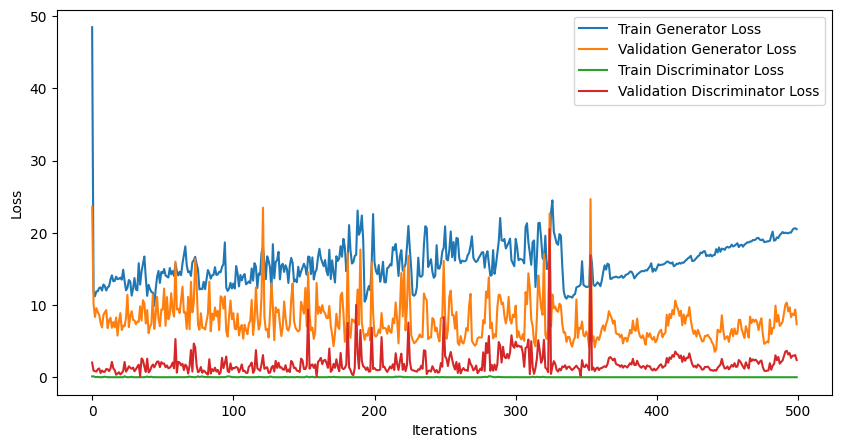

In [43]:
# Plot losses

plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Train Generator Loss")
plt.plot(G_losses_val, label="Validation Generator Loss")
plt.plot(D_losses, label="Train Discriminator Loss")
plt.plot(D_losses_val, label="Validation Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Check result

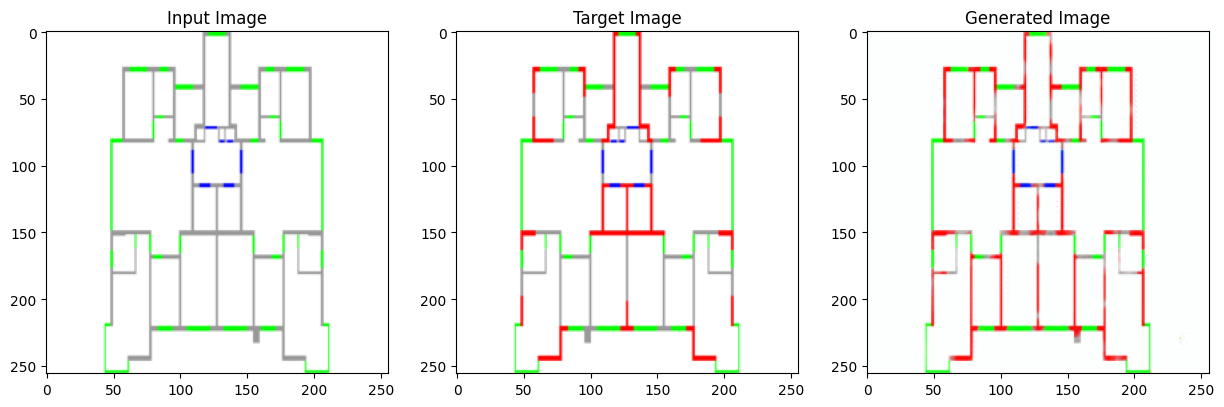

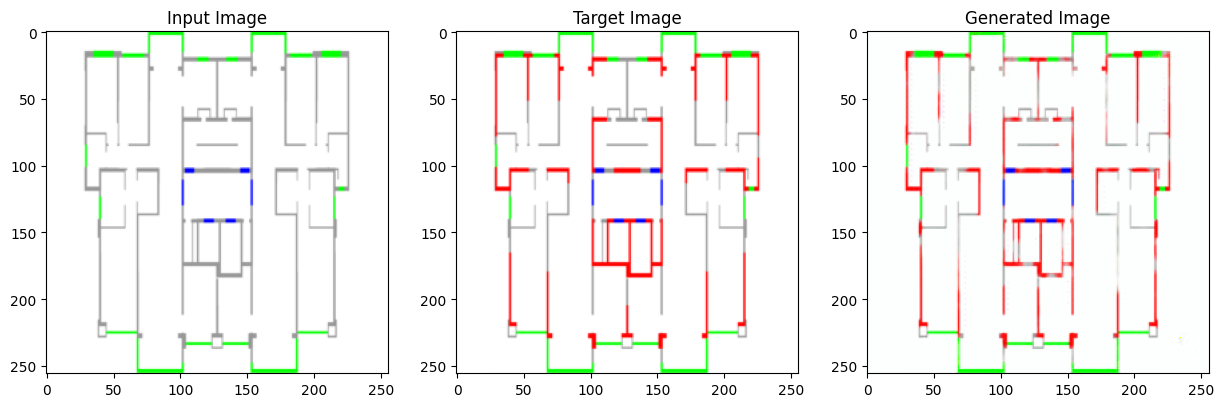

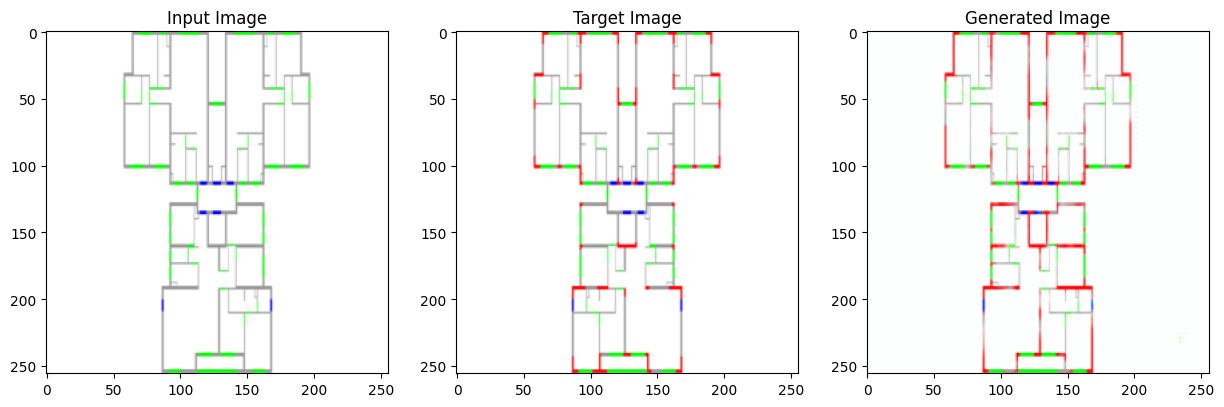

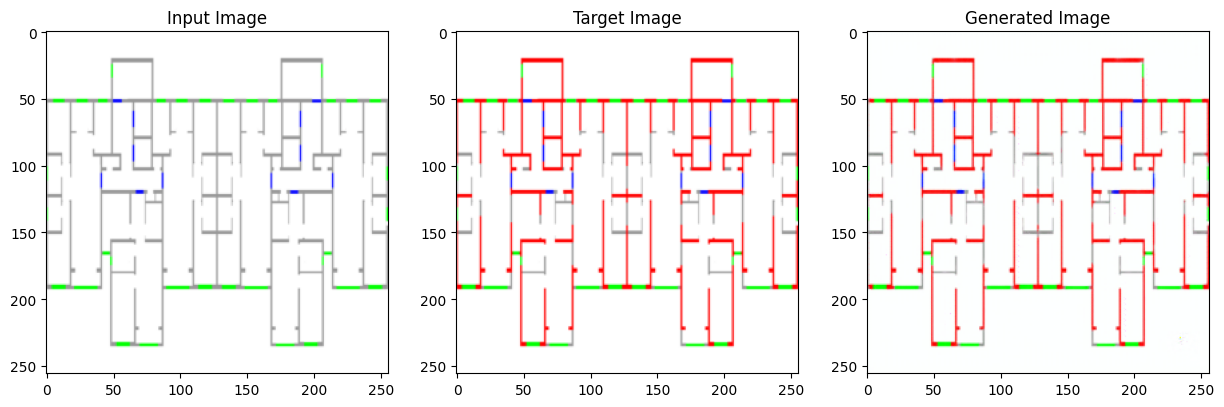

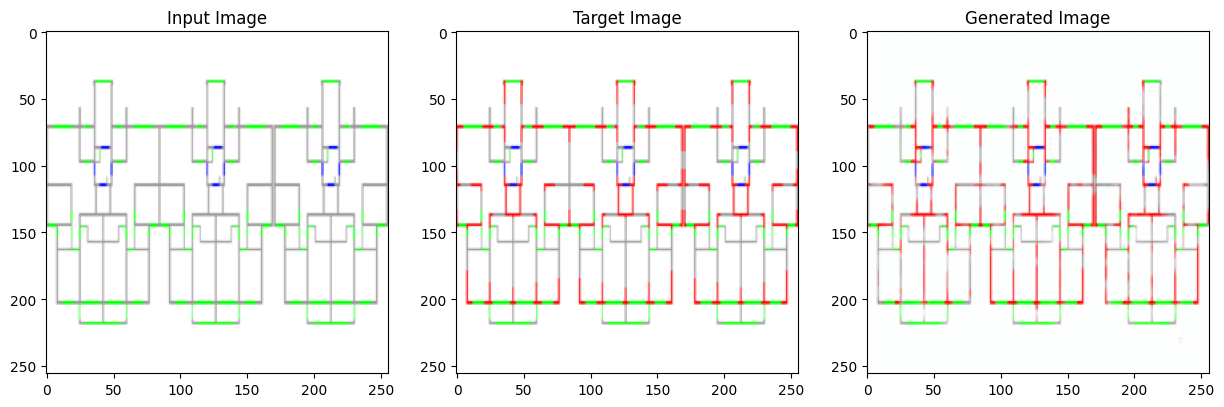

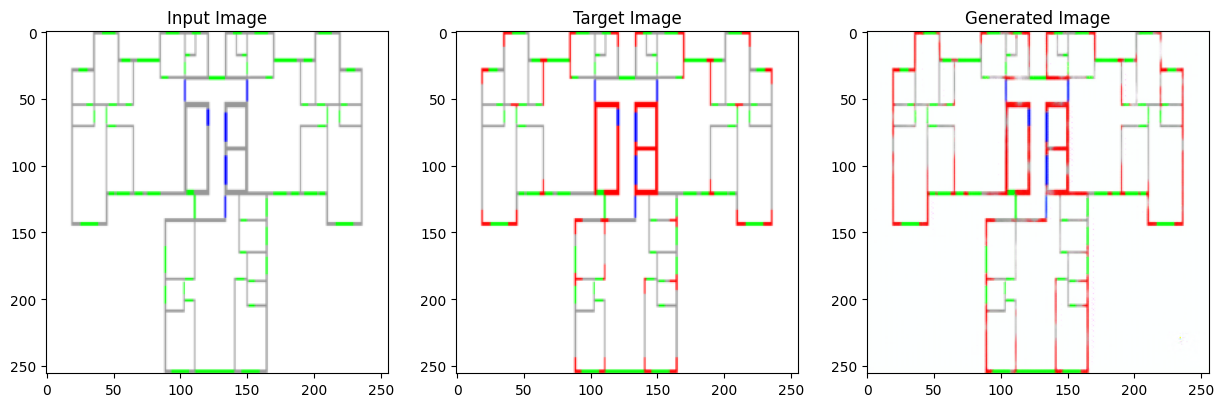

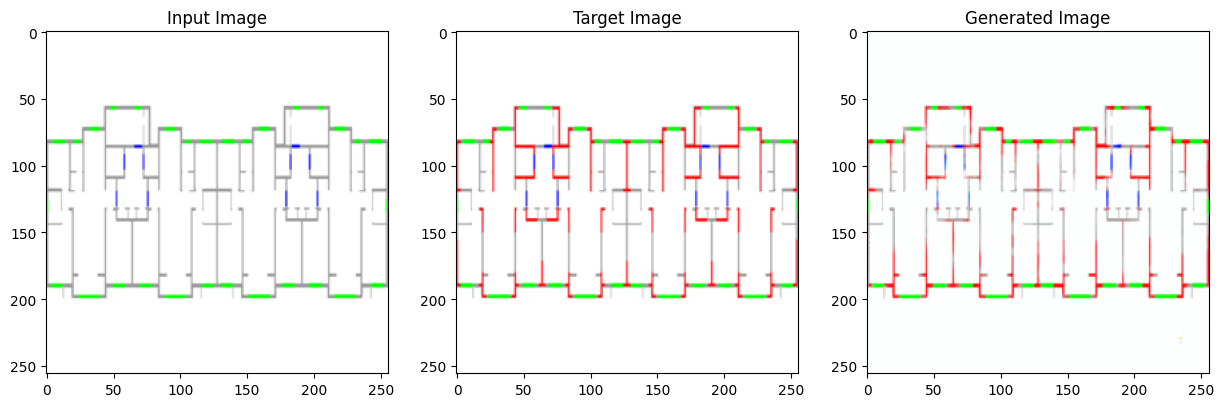

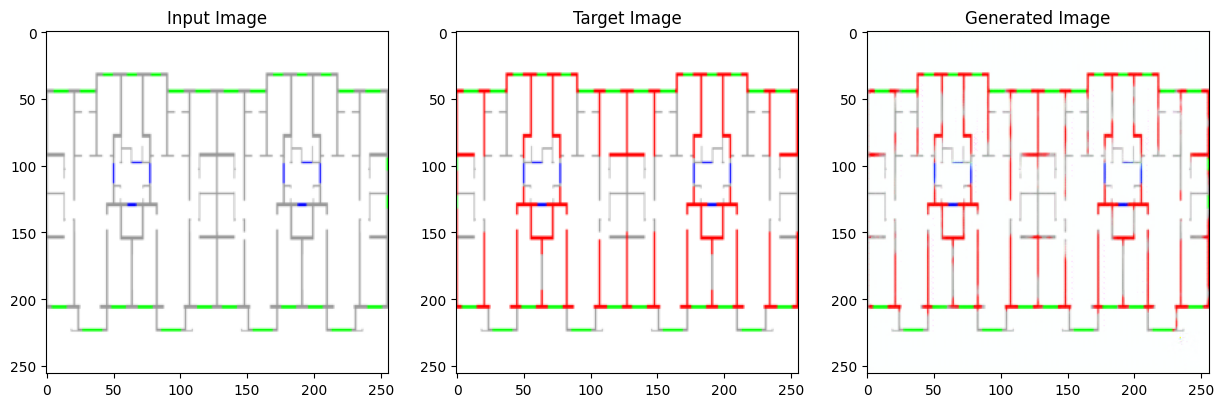

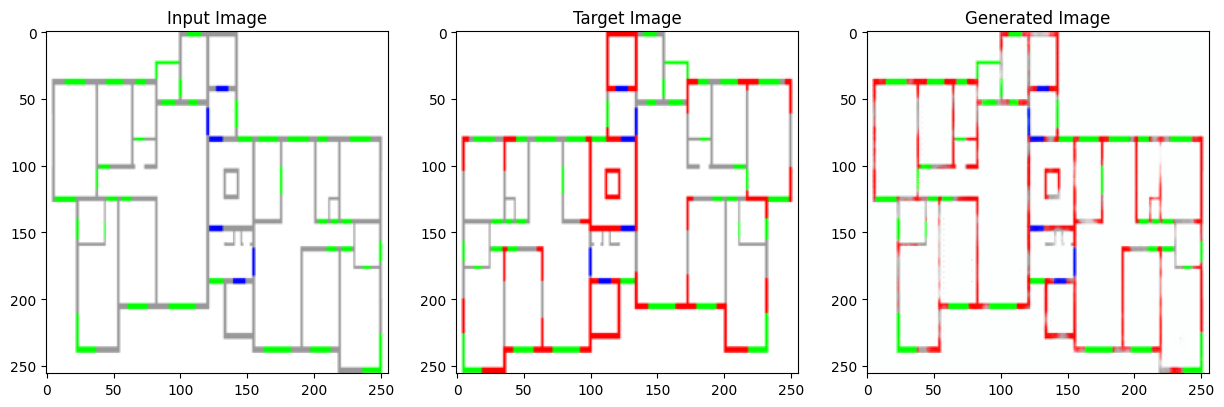

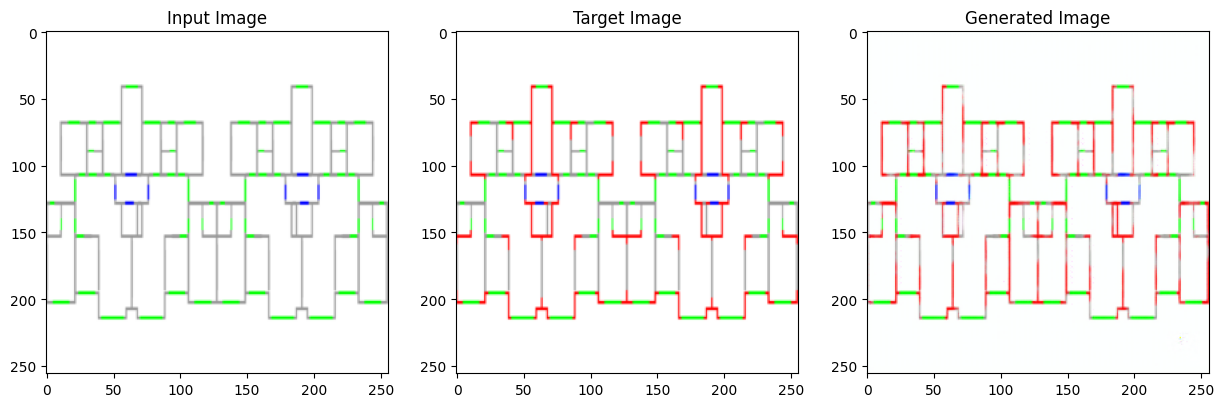

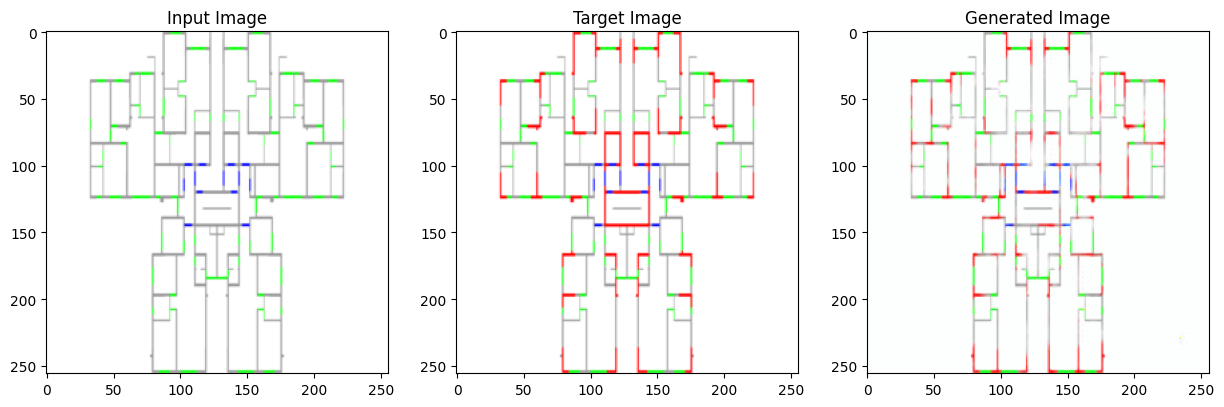

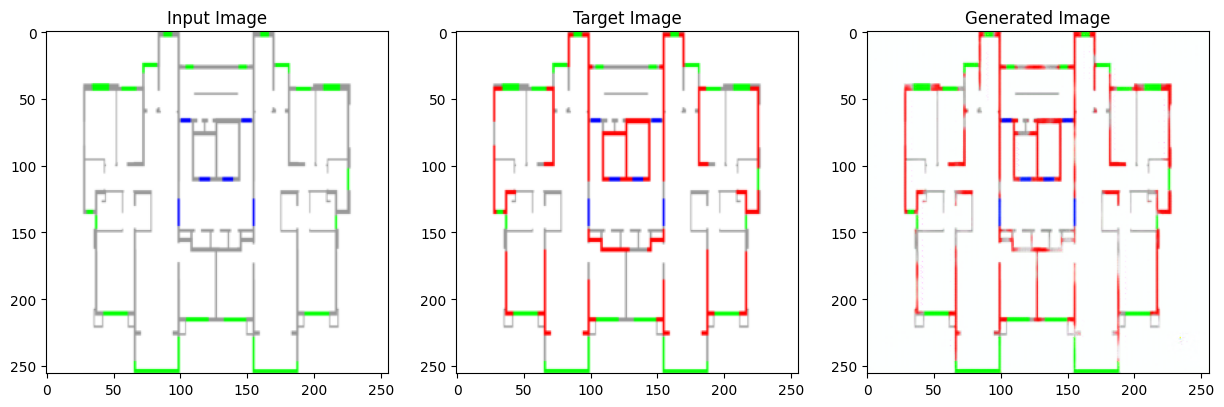

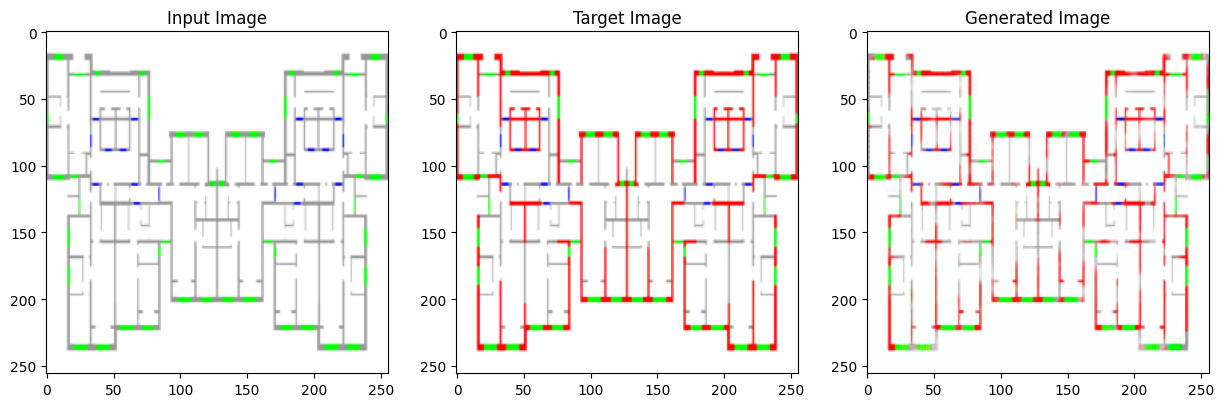

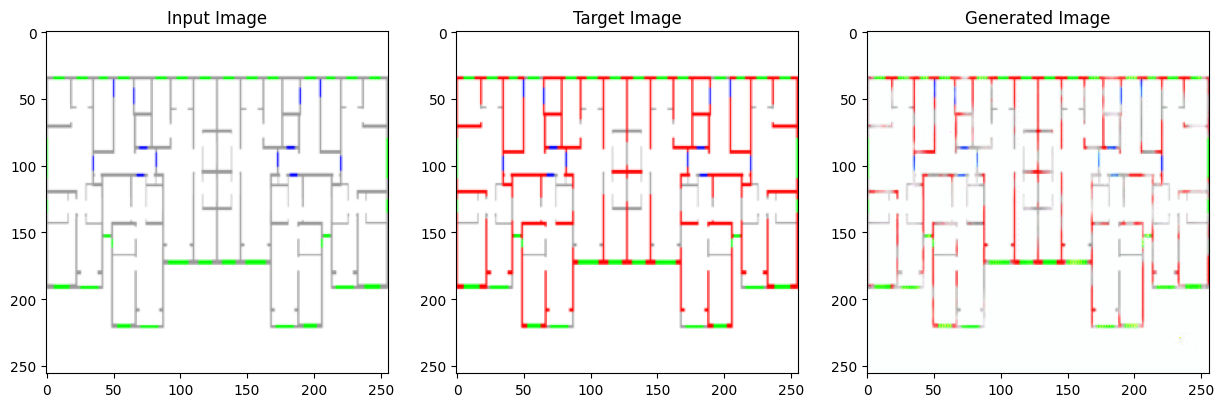

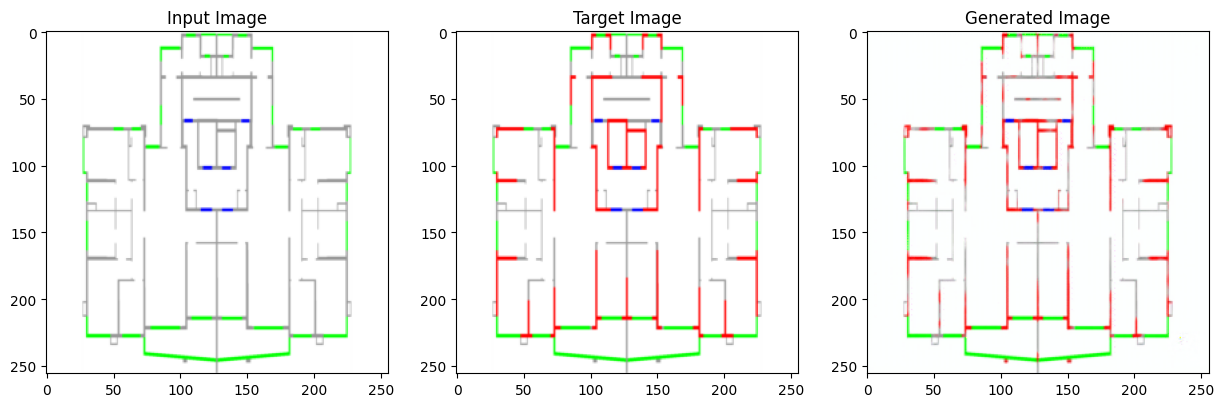

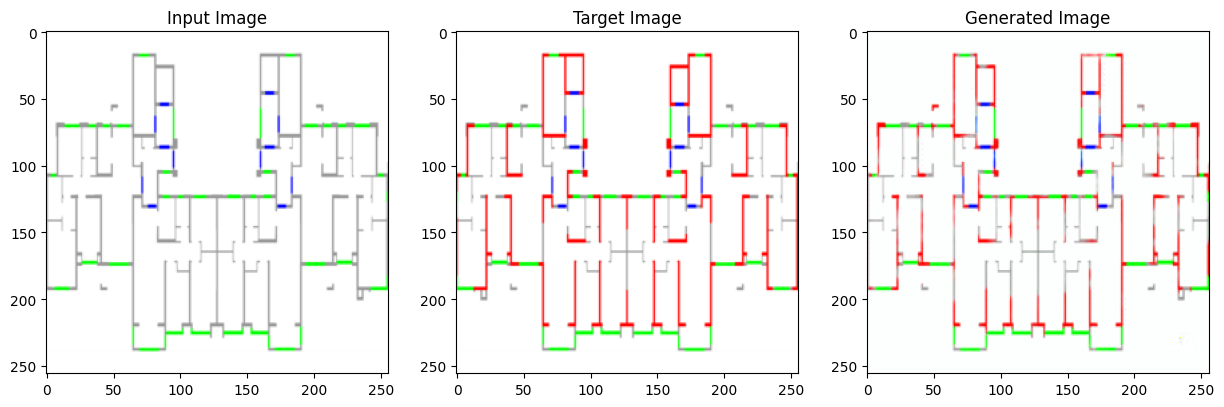

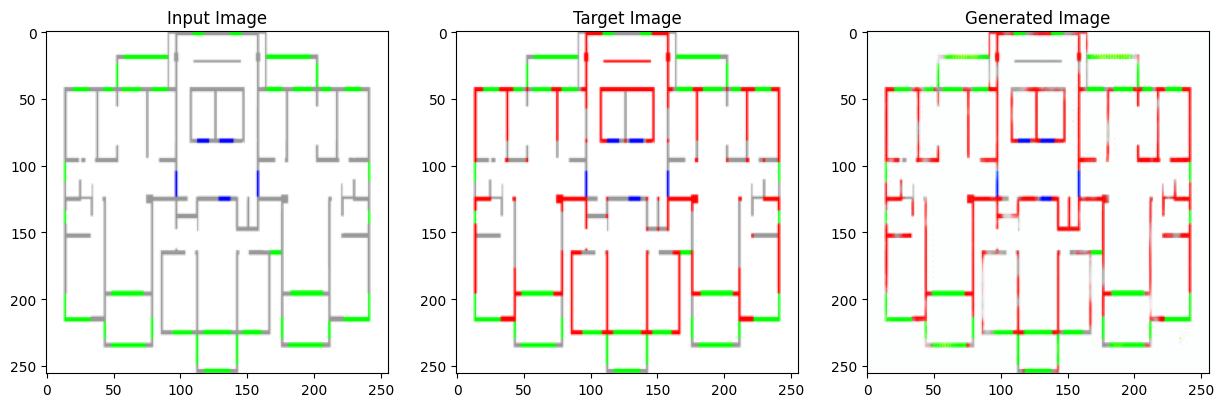

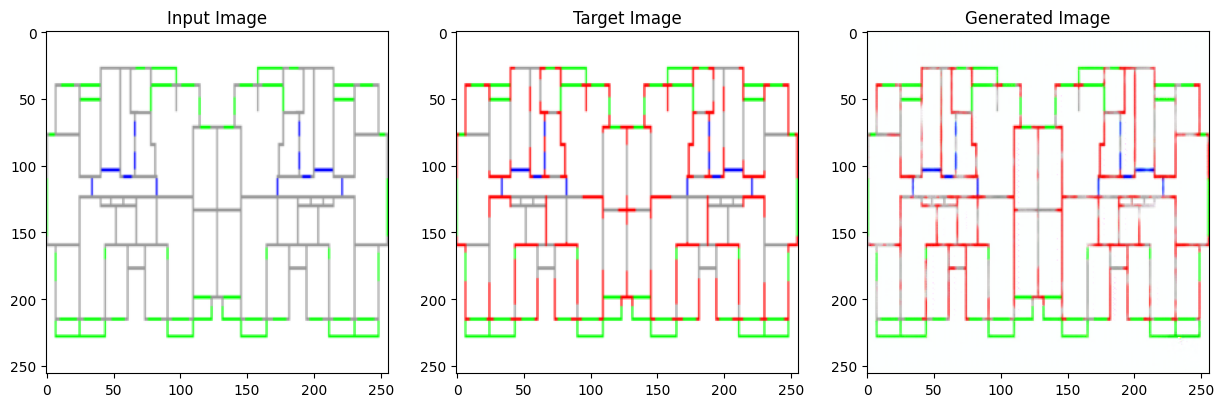

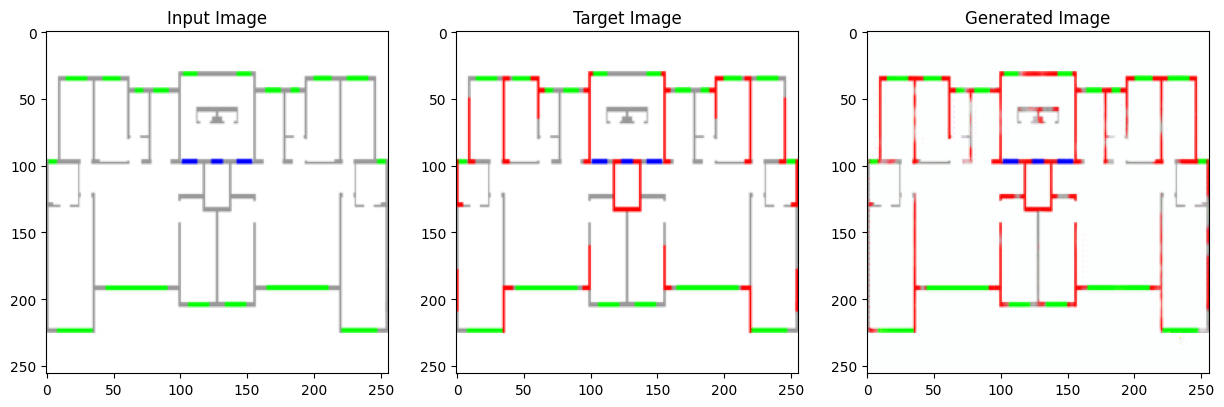

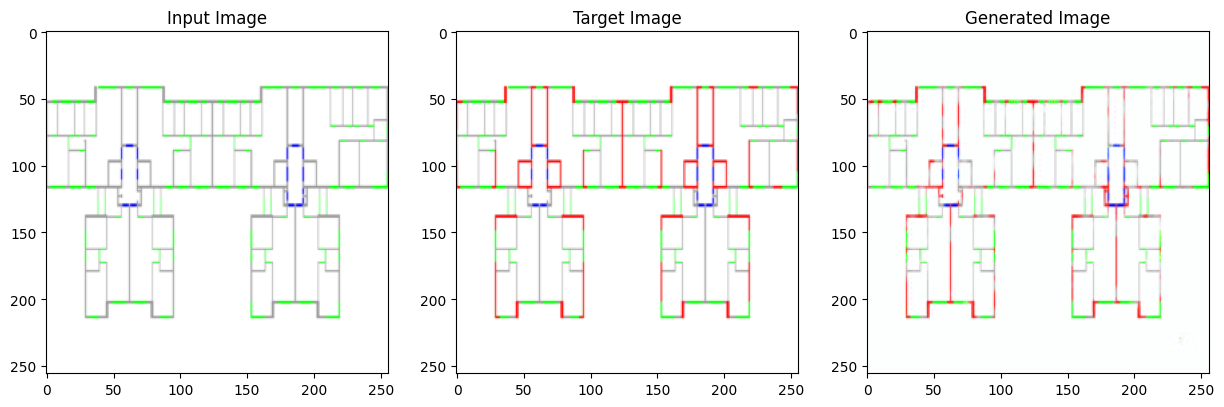

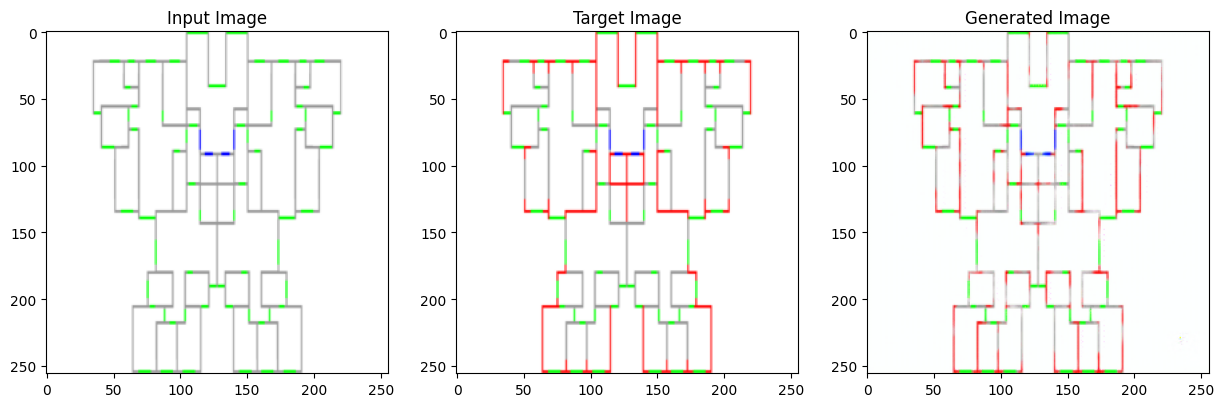

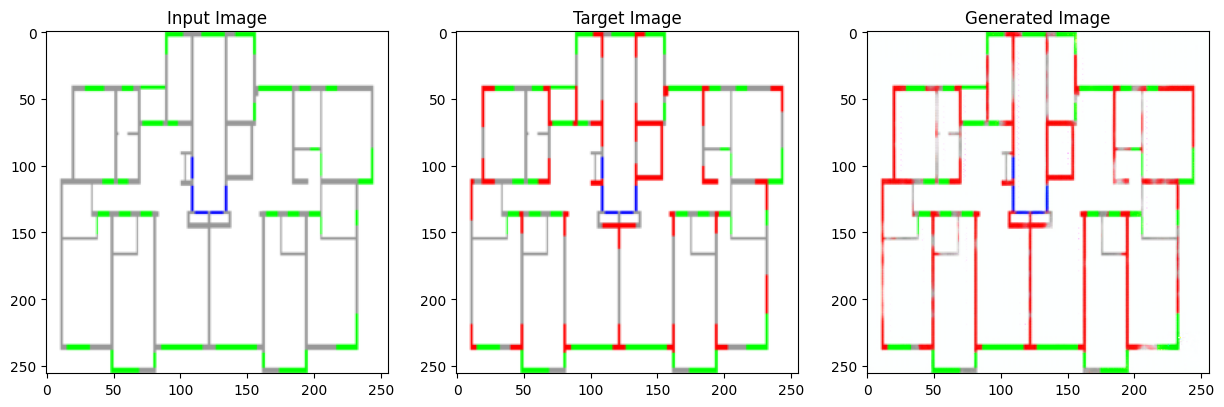

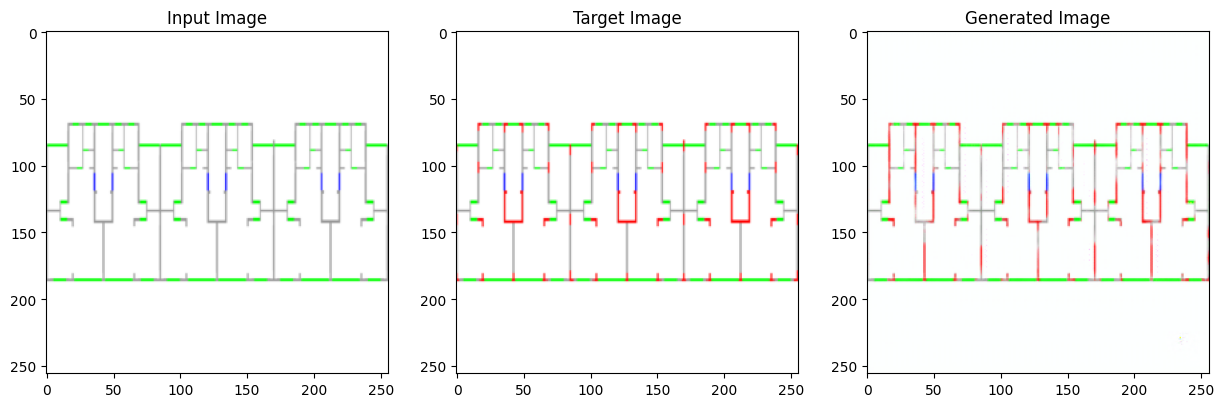

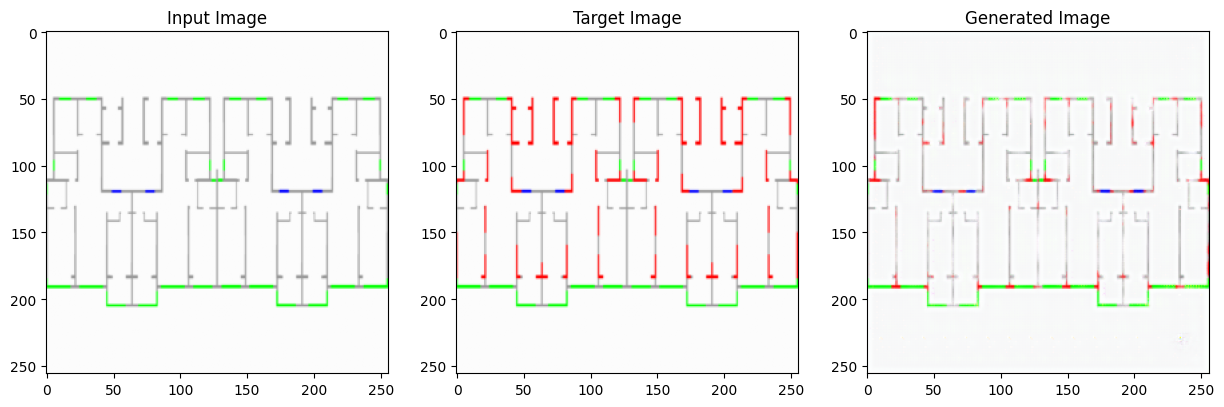

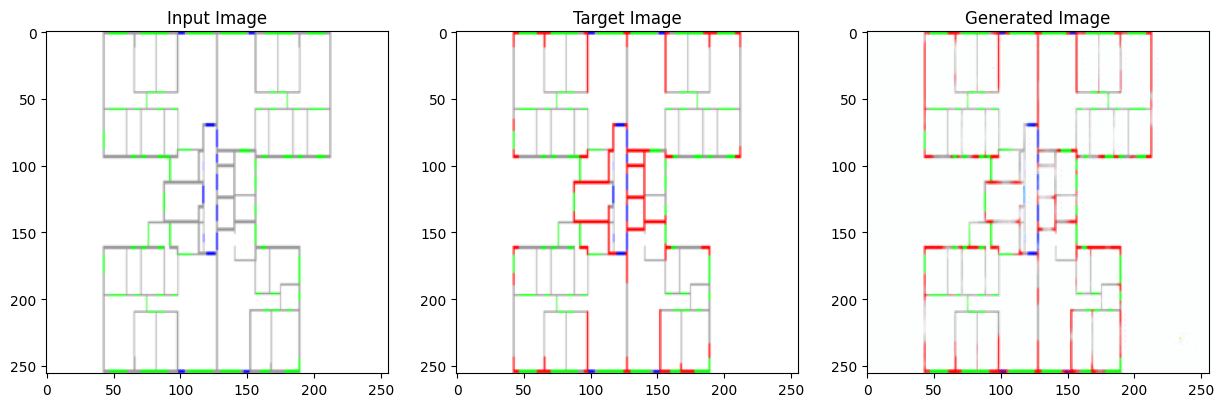

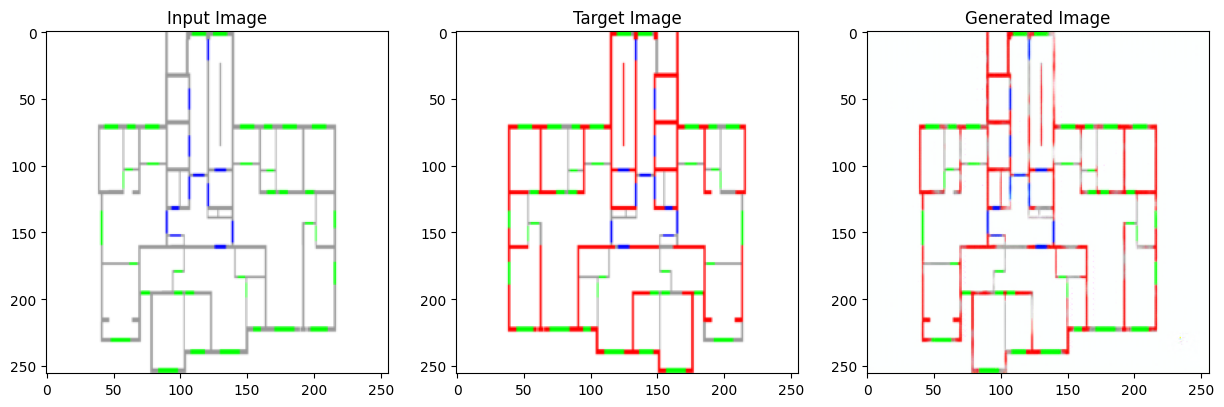

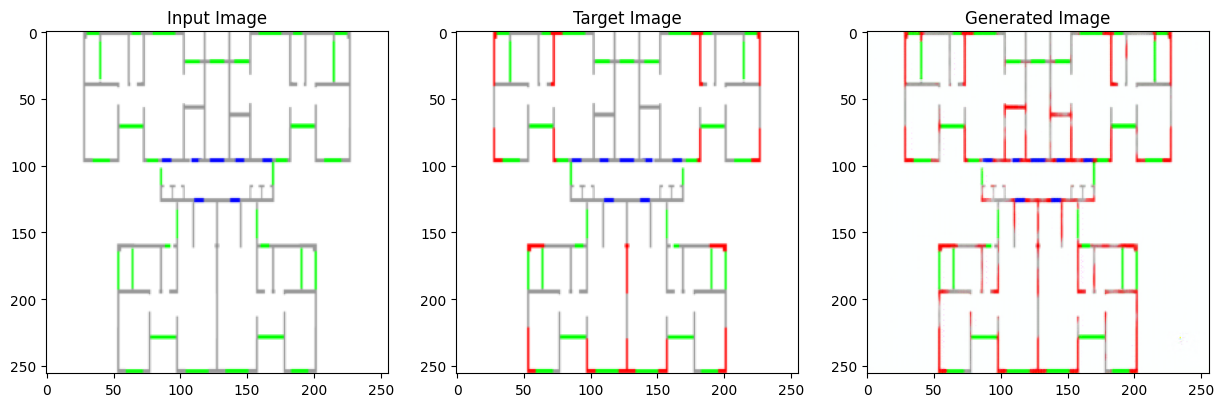

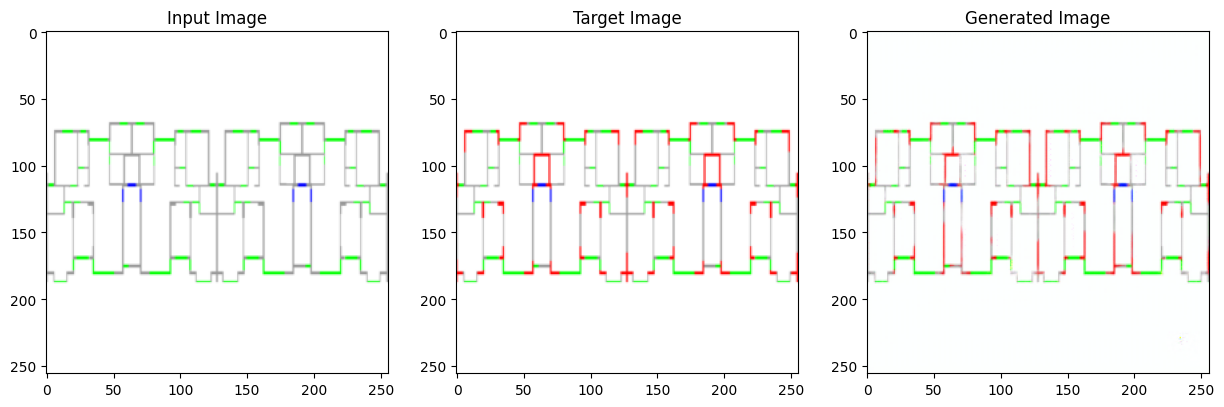

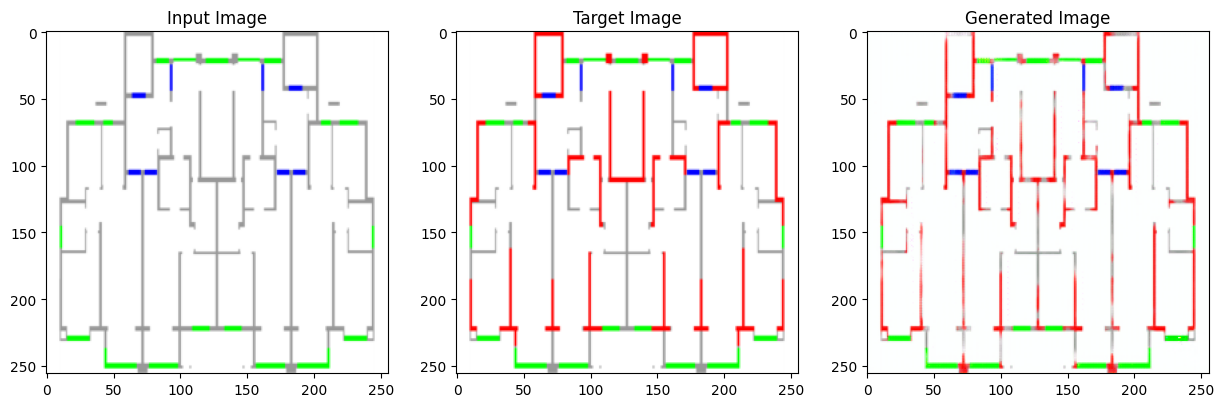

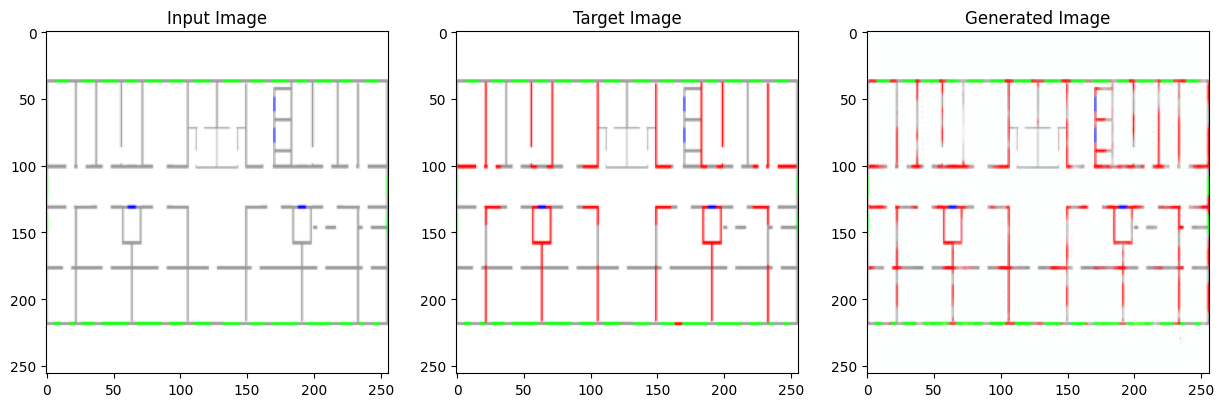

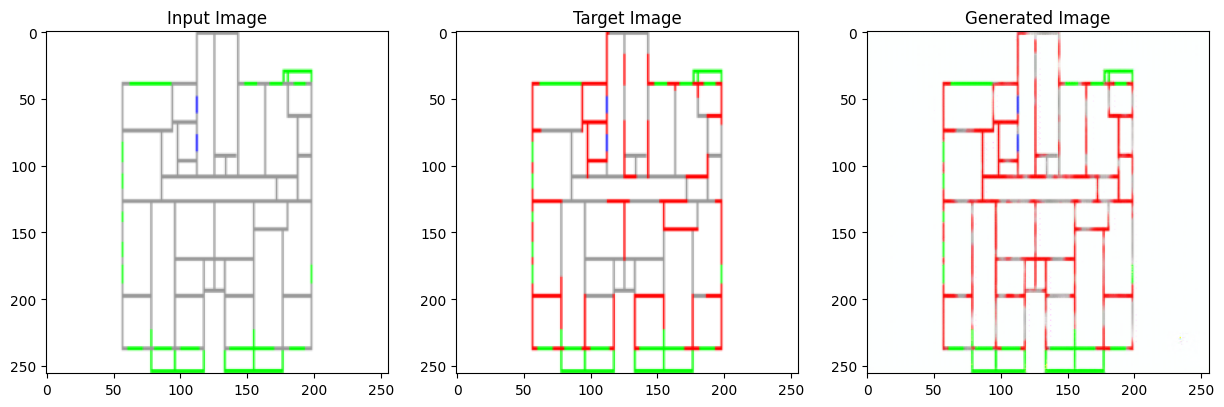

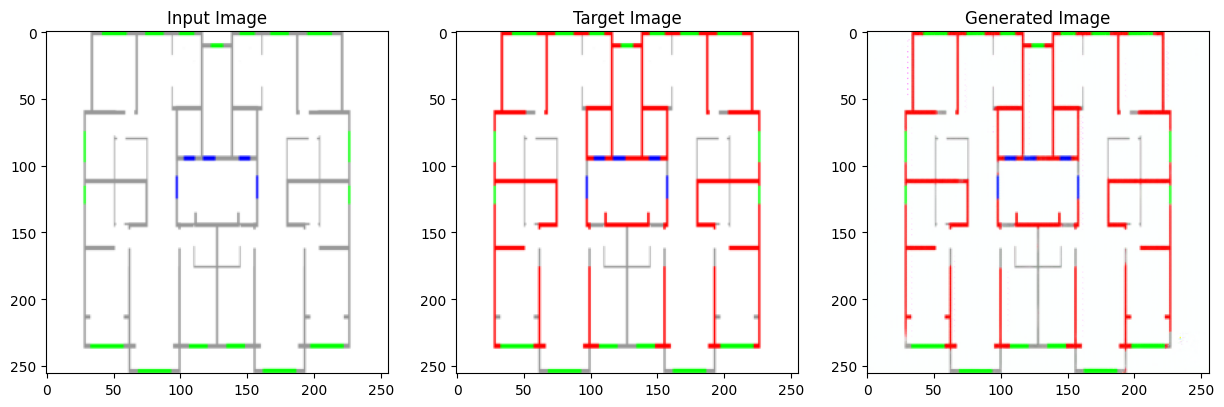

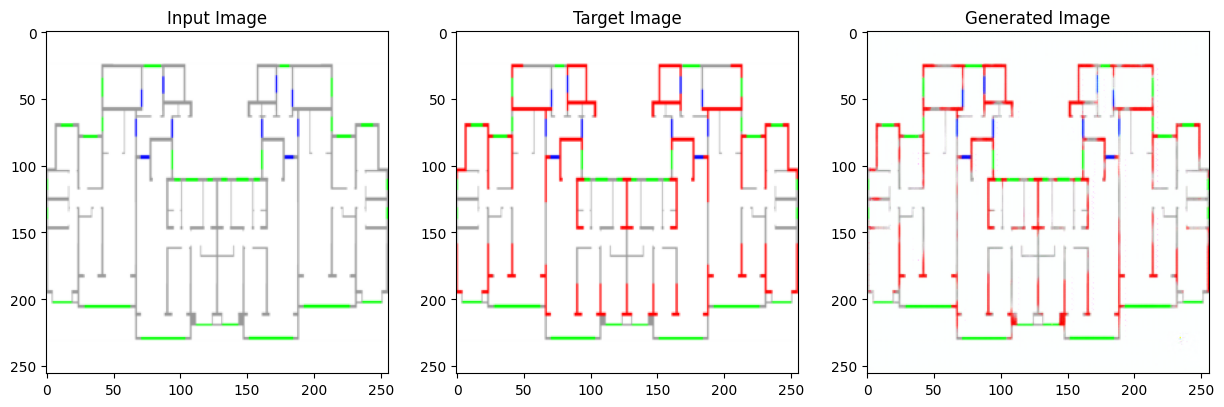

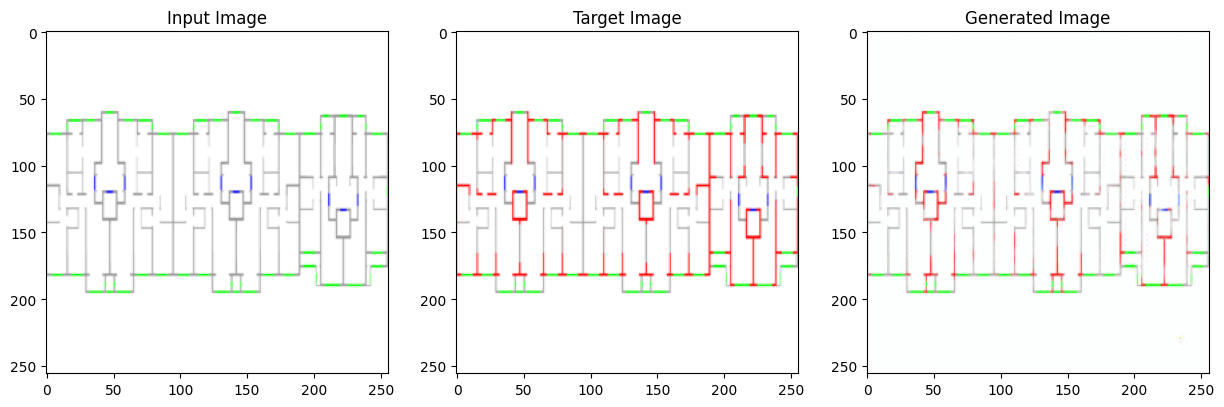

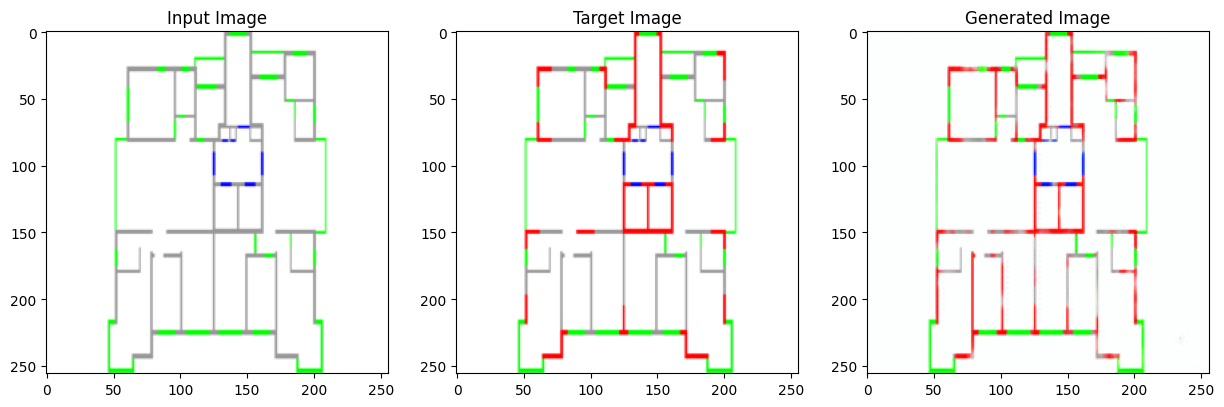

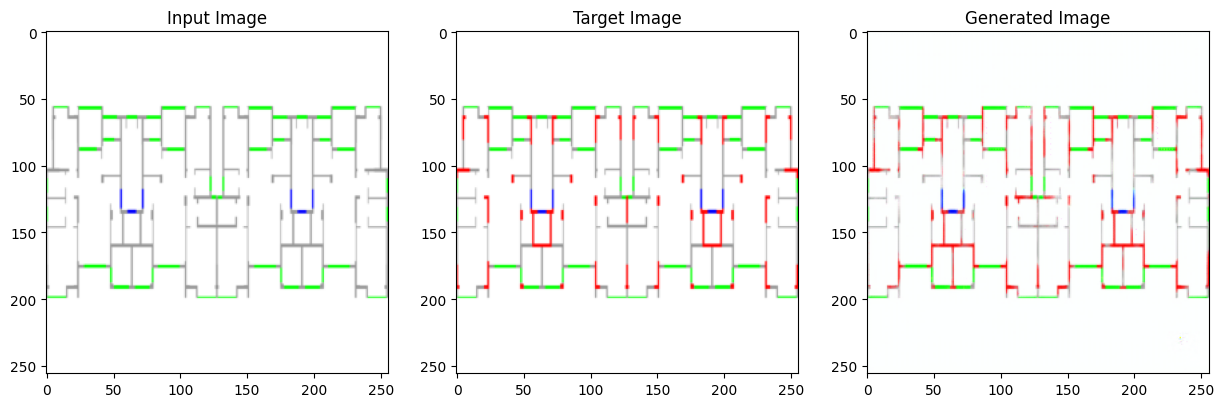

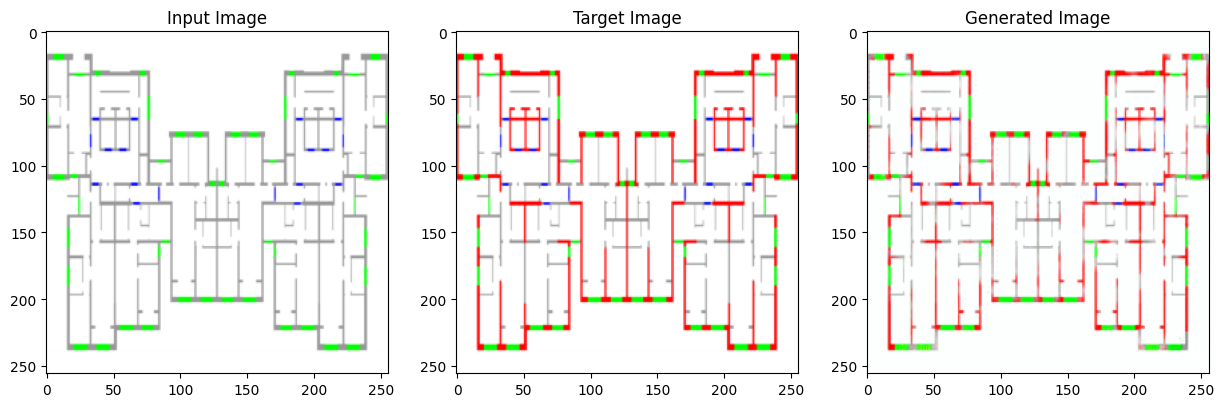

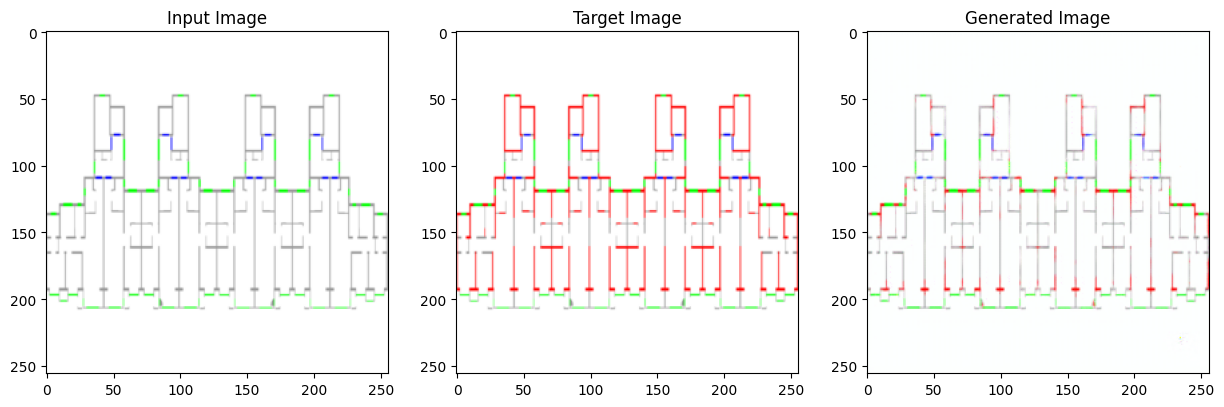

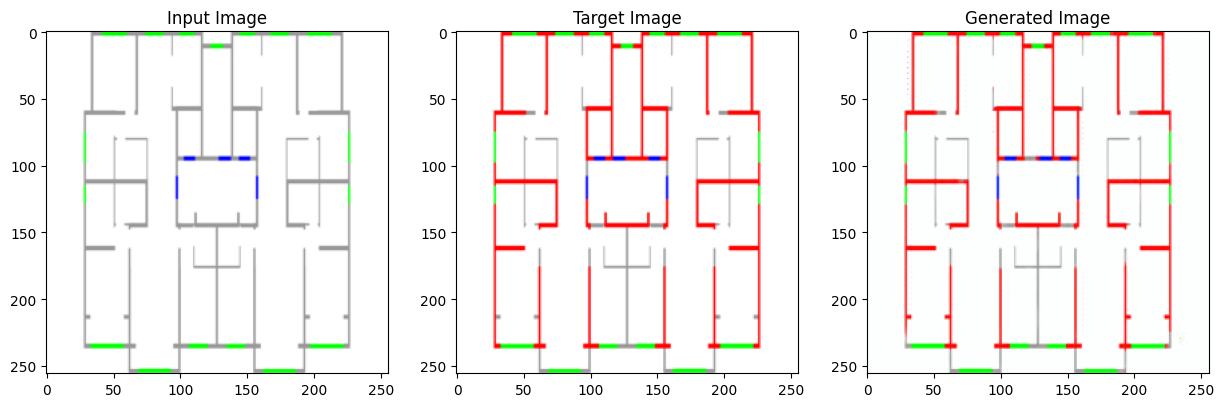

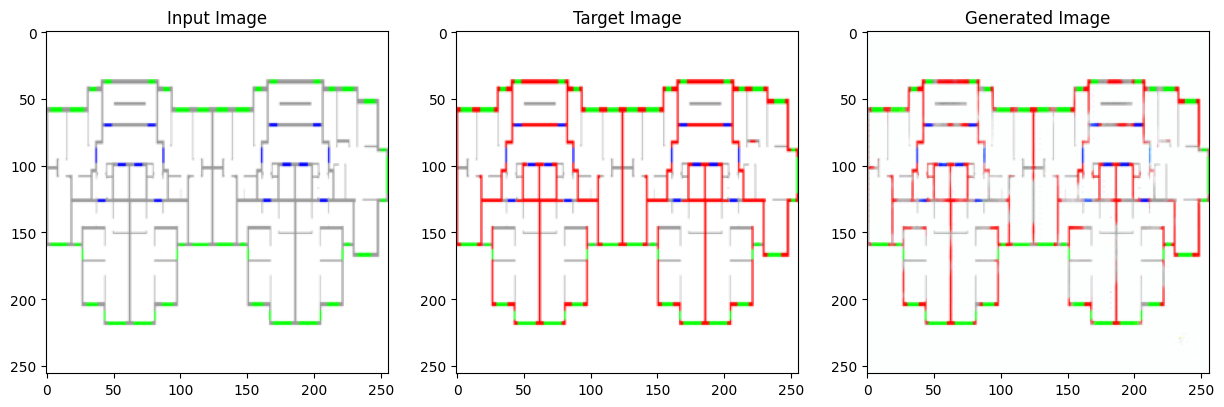

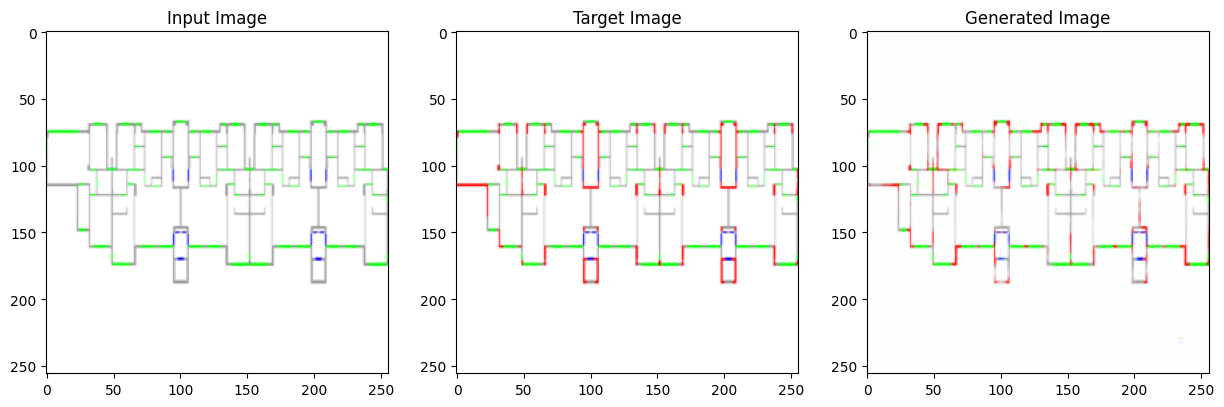

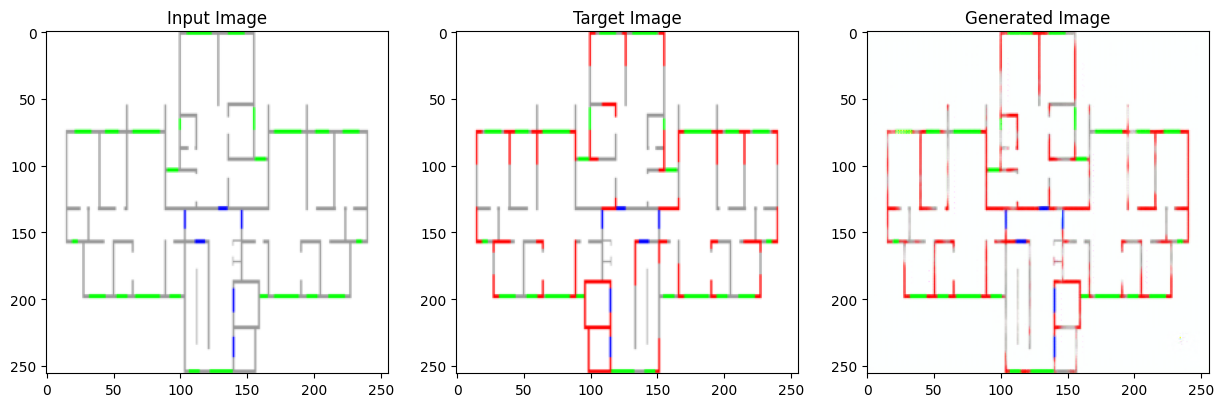

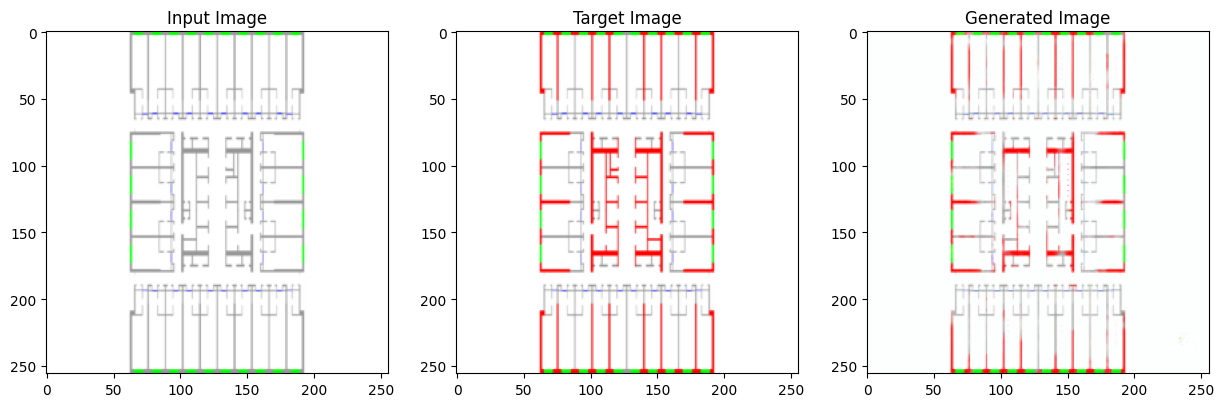

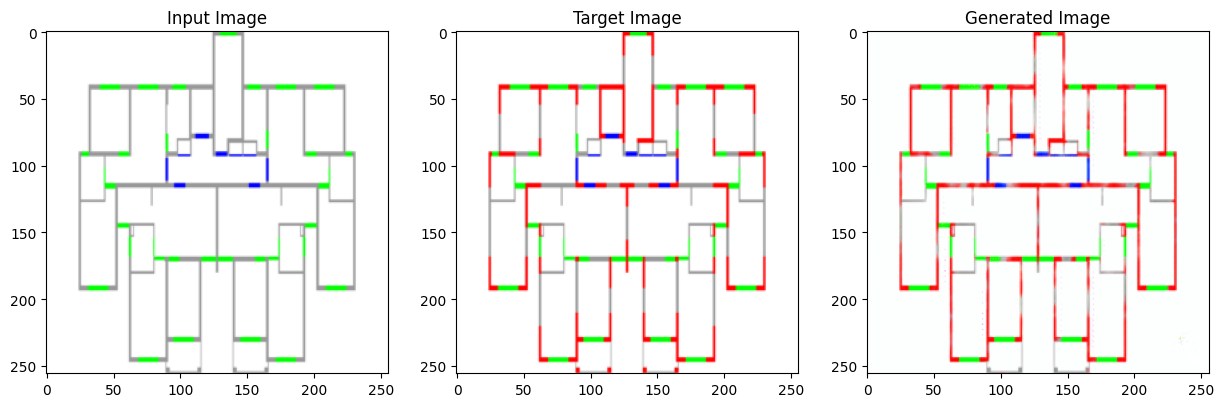

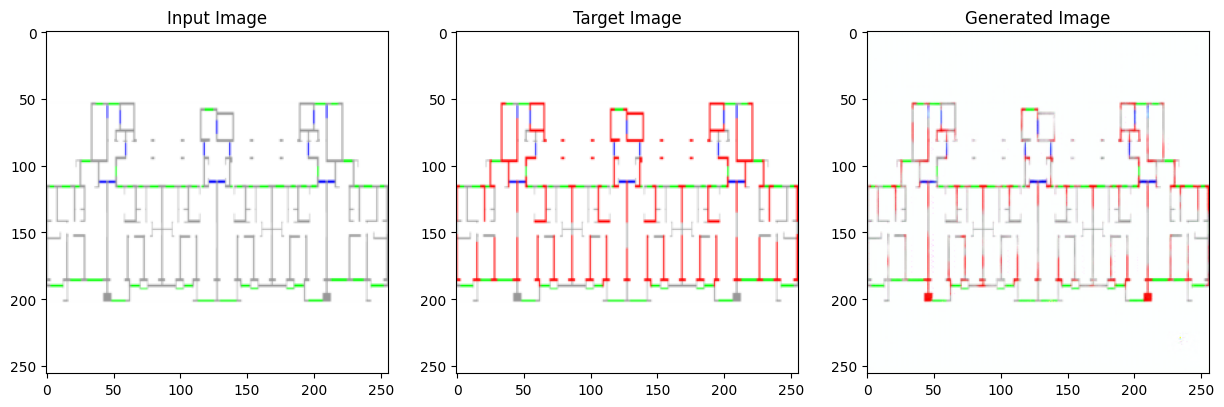

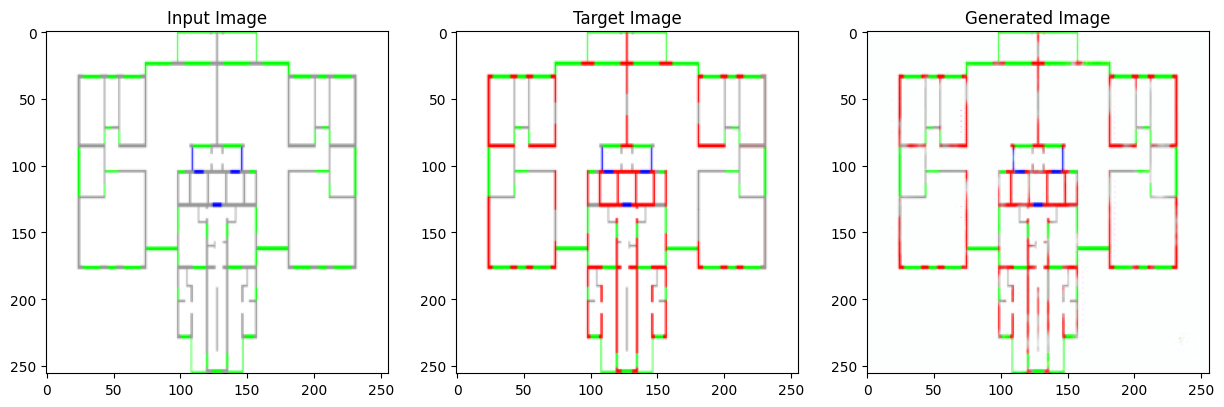

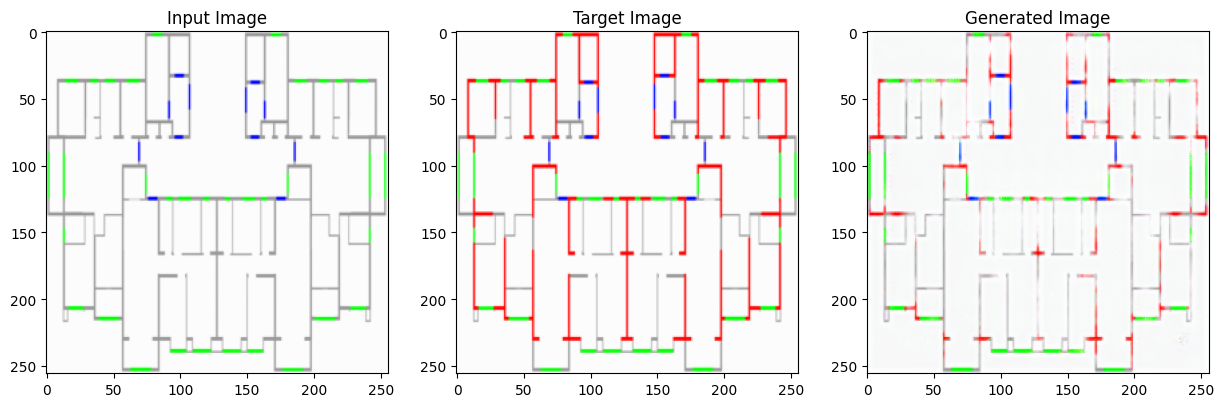

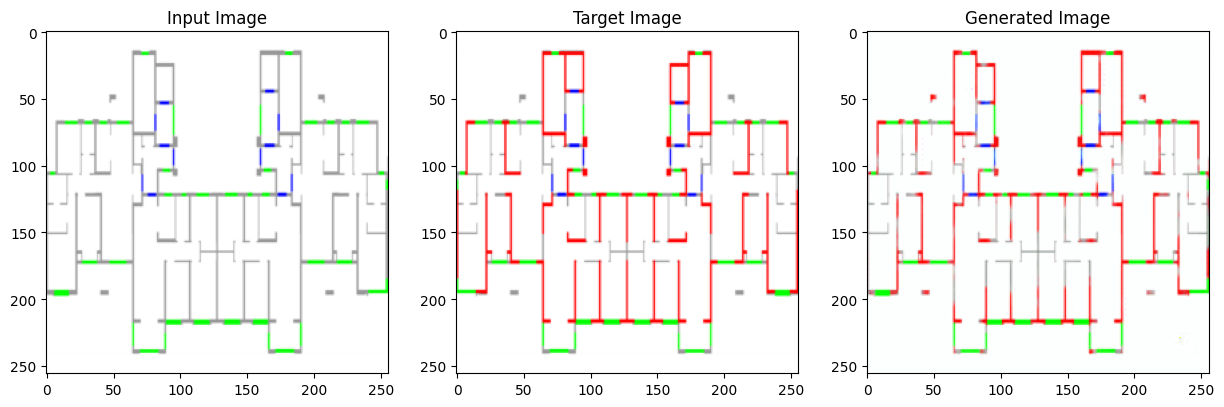

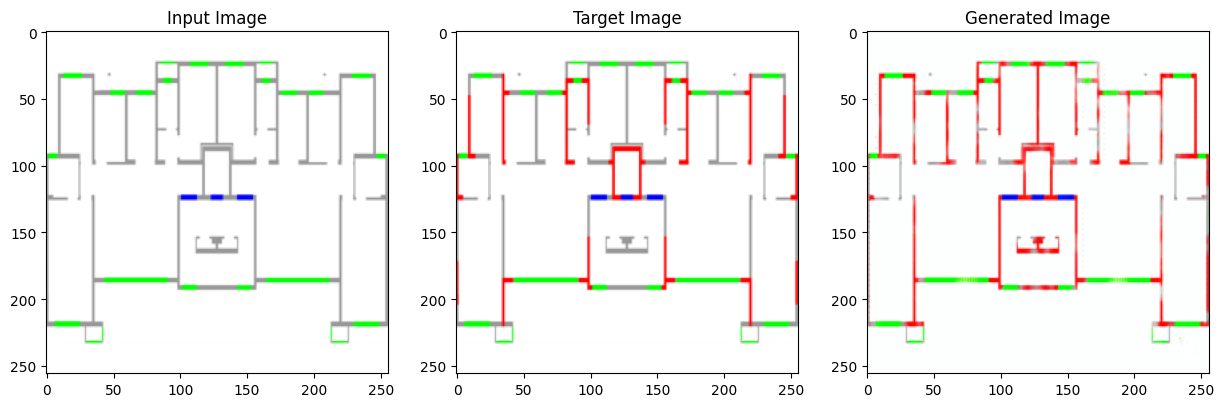

In [44]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def image_generator(test_loader, generator, device):
    """
    Generates and displays images using the generator model.

    Args:
        test_loader: DataLoader for the test set.
        generator: The generator model.
        device: The device (CPU or GPU) to use for computations.
    """
    generator.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculations
        for input_images, target_images in test_loader:
            input_images = input_images.to(device)
            target_images = target_images.to(device)
            fake_images = generator(input_images)

            # Display the input, target, and generated images
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(np.transpose(input_images[0].cpu().numpy(), (1, 2, 0)))  # Assuming batch size is 1
            plt.title("Input Image")

            plt.subplot(1, 3, 2)
            plt.imshow(np.transpose(target_images[0].cpu().numpy(), (1, 2, 0)))  # Assuming batch size is 1
            plt.title("Target Image")

            plt.subplot(1, 3, 3)
            plt.imshow(np.transpose(fake_images[0].cpu().numpy(), (1, 2, 0)))  # Assuming batch size is 1
            plt.title("Generated Image")

            plt.show()
            yield fake_images  # Yield the generated images (optional)

# Example usage:
# Assuming generator, test_loader, and device are already defined
for generated_images in image_generator(test_loader, generator, torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    # You can process the generated_images here, e.g., save them to a file
    pass